## **Загрузка**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go 

# Машинное обучение
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/CSV

Mounted at /content/drive/
/content/drive/My Drive/CSV


In [3]:
data = pd.read_csv('gender.csv', usecols=range(1,23))

In [4]:
data.info(null_counts =1) 
print('\nКоличество повторяющихся строк —', data.duplicated().sum())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                2515 non-null   int64  
 1   long_hair                            2515 non-null   float64
 2   forehead_width_cm                    2515 non-null   float64
 3   forehead_height_cm                   2515 non-null   float64
 4   forehead_width_mm                    2515 non-null   float64
 5   forehead_width_conventional_units    2515 non-null   float64
 6   nose_wide                            2515 non-null   float64
 7   nose_long                            2515 non-null   float64
 8   lips_thin                            2515 non-null   float64
 9   distance_nose_to_lip_long            2515 non-null   float64
 10  gender                               1514 non-null   object 
 11  index.1                       

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender,index.1,long_hair.1,forehead_width_cm.1,forehead_height_cm.1,forehead_width_mm.1,forehead_width_conventional_units.1,nose_wide.1,nose_long.1,lips_thin.1,distance_nose_to_lip_long.1,gender.1
0,0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN,2515,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN,2516,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN,2517,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN,2518,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN,2519,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


In [5]:
2515 + 2486

5001

1.   Столбцы с ".1" продолжают одноимённые без ".1", следовательно, столбцы без единиц надо скленить со столбцами с единицами. 
2.   Убрать столбец **forehead_width_mm**, т.к. он дублирует столбец **forehead_width_cm**.


# **Предобработка**

## Совмещение и удаление столбцов

In [6]:
data_1 = data[data.columns[~(data.columns.str.endswith('.1'))]]
data_2 = data[data.columns[data.columns.str.endswith('.1')]]
data_2.columns = data_1.columns
data_2 = data_2.drop(data_2[data_2.long_hair.isna()==True].index)
data_cleaned = data_1.append(data_2, ignore_index=True)
data_cleaned = data_cleaned.drop(data_cleaned.columns[data_cleaned.columns.str.endswith('.1')],axis=1)
data_cleaned = data_cleaned.drop('forehead_width_mm',axis=1)

In [7]:
data_cleaned.info(null_counts =1) 
print('\nКоличество повторяющихся строк —', data_cleaned.duplicated().sum())
display(data_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              5001 non-null   int64  
 1   long_hair                          5001 non-null   float64
 2   forehead_width_cm                  5001 non-null   float64
 3   forehead_height_cm                 5001 non-null   float64
 4   forehead_width_conventional_units  5001 non-null   float64
 5   nose_wide                          5001 non-null   float64
 6   nose_long                          5001 non-null   float64
 7   lips_thin                          5001 non-null   float64
 8   distance_nose_to_lip_long          5001 non-null   float64
 9   gender                             4000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB

Количество повторяющихся строк — 0


,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,0,0.704275,11.8,6.1,0.025806,0.895614,0.477485,0.841261,0.902628,NaN
1,1,0.118690,14.0,5.4,0.167742,0.202520,0.186825,0.719697,0.309122,NaN
2,2,0.203894,11.8,6.3,0.025806,0.892793,0.723152,0.725821,0.720640,NaN
3,3,0.386228,14.4,6.1,0.193548,0.024963,0.562005,0.831515,0.770379,NaN
4,4,0.564020,13.5,5.9,0.135484,0.415389,0.063705,0.211584,0.157217,NaN


## Сглаживание погрешности
*   [0,0.5) -> 0
*   [0.5, 1) -> 1

In [8]:
for column in ('nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair'):
  data_cleaned[column] = np.where((data_cleaned[column] >=0)&(data_cleaned[column] <0.5), 0, data_cleaned[column])
  data_cleaned[column] = np.where((data_cleaned[column] >=0.5)&(data_cleaned[column] <1), 1, data_cleaned[column])

## Нумеризация пола


In [9]:
len(data_cleaned[data_cleaned['gender'].isna()==True])

1001

In [10]:
data_cleaned.gender.value_counts()

Female    2006
Male      1994
Name: gender, dtype: int64

In [11]:
data_cleaned['gender'] = data_cleaned['gender'].map({'Male':1,'Female':0})

In [12]:
data_cleaned.gender.value_counts()

0.0    2006
1.0    1994
Name: gender, dtype: int64

# **Расчёты**

## Отбор признаков

In [13]:
# Построение графиков
def draw_chart(data, kind, data_y=None, data_x=None, title=None, xlabel=None, ylabel = None
               , height=None, width=None
               , vmax=None, fmt=None, color = None, color_name=None):
     # Тепловая карта     
    if kind == 'heatmap':
        sns.set(style='white')
        plt.figure(figsize=(16, 9)) 
        plt.title(title, fontsize=16)
        fig = sns.heatmap(data, annot=True, linewidths=1, linecolor='gray', fmt=fmt)
        plt.xticks(rotation=45) 
        plt.gcf().autofmt_xdate()    
    return fig  

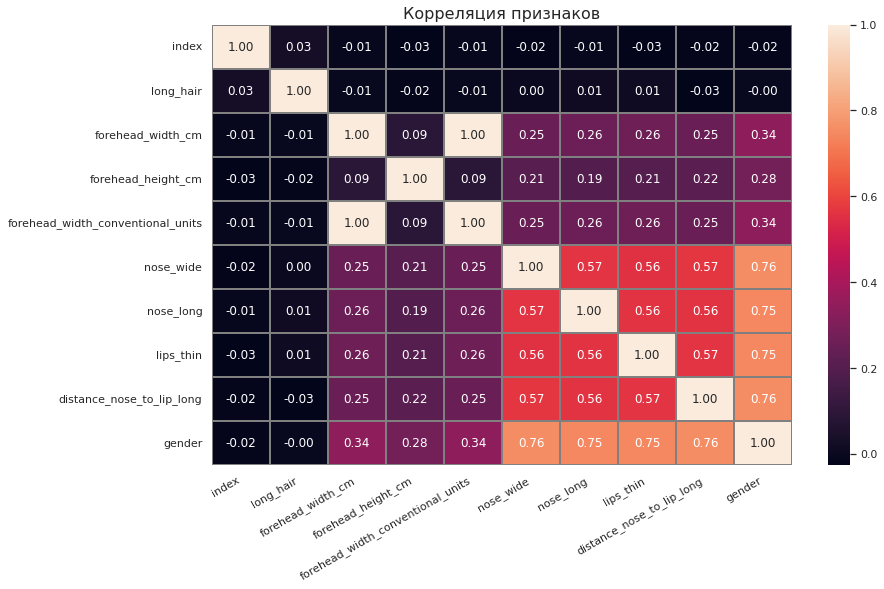

In [14]:
corr = data_cleaned.corr()
draw_chart(corr, kind='heatmap',title='Корреляция признаков', fmt='.2f');

Больше всего пол зависит от следующих черт:
* nose_wide
* nose_long
* lips_thin
* distance_nose_to_lip_long
* forehead_width_conventional_units




In [15]:
data_cleaned_2 = data_cleaned[['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'forehead_width_conventional_units', 'gender']]

## Обучение модели

In [16]:
test = data_cleaned_2.query('gender != gender')[data_cleaned_2.columns[0:-1]]

In [17]:
train = data_cleaned_2.query('gender == gender')

In [18]:
model_test = RandomForestClassifier(random_state=1)
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

params = [{
    'n_estimators': [350, 400, 500, 1000],
    'min_samples_split': [6, 8, 10, 12],
    'min_samples_leaf': [2, 4, 6]
}]
grid = GridSearchCV(model_test, params, cv=cv, refit=True, verbose=1, n_jobs=-1)
grid.fit(train[train.columns[0:-1]], train['gender'])

best = grid.best_estimator_
print('Accuracy (random forest auto): {} with params {}'
      .format(grid.best_score_, grid.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.4min finished


Accuracy (random forest auto): 0.9692520581419718 with params {'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 350}


In [ ]:
model = RandomForestClassifier(random_state=1, n_estimators=350, min_samples_split=6, min_samples_leaf=4)

In [ ]:
model.fit(train[train.columns[0:-1]], train['gender']);

In [ ]:
prediction = model.predict(test)

# Bыгрузка

In [ ]:
rt = pd.DataFrame({
    'id': test['nose_wide'],
    'gender': prediction
})

In [ ]:
rt['gender'] = rt['gender'].map({1:'Male',0:'Female'})

In [ ]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1001 non-null   float64
 1   gender  1001 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [ ]:
rt.drop('id', axis=1).to_csv('gender_matveeva-a.csv', index=False, header=False)